In [1]:
import moxing as mox
 
mox.file.copy_parallel('obs://modelsarts-eric/cifar10-Lenet/', '/home/ma-user/work')


INFO:root:Using MoXing-v2.1.0.5d9c87c8-5d9c87c8
INFO:root:Using OBS-Python-SDK-3.20.9.1


In [2]:
from mindspore import context
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import mindspore.dataset as ms
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype

import os
def creat_dataset(dir,training=True,batch_size=32):
    
    data_dir=os.path.join(dir)

   
    ds=ms.Cifar10Dataset(data_dir,usage='train' if training else 'test')
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / (0.3081)
    shift_nml = -1 * 0.1307 / 0.3081
    batch_size=32

    
    ds=ds.map(input_columns=['image'],operations=[CV.Rescale(rescale_nml,shift_nml),CV.HWC2CHW()])
    ds = ds.shuffle(buffer_size=64).batch(batch_size, drop_remainder=True)
    type_cast_op=C.TypeCast(mstype.int32)
    ds = ds.map(operations=type_cast_op, input_columns="label")

    return ds

In [3]:
ds_train=creat_dataset('cifar-10-batches-bin/')
ds2_test=creat_dataset('cifar-10-batches-bin/',False)

In [4]:
from mindspore import nn
class LeNet5(nn.Cell):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.conv1=nn.Conv2d(3,32,5,stride=1,pad_mode='same')
        self.conv2=nn.Conv2d(32,64,3,stride=1,pad_mode='same')
        self.conv3=nn.Conv2d(64,128,3,stride=1,pad_mode='same')
        # self.conv4=nn.Conv2d(120,128,3,stride=1,pad_mode='valid')
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout=nn.Dropout(0.3)
        self.flatten=nn.Flatten()
        self.fc1=nn.Dense(2048  ,120)
        self.fc2=nn.Dense(120,84)
        # self.fc3=nn.Dense(84,64)
        self.fc3=nn.Dense(84,10)
        self.softmax=nn.Softmax()
    
    def construct(self,x):
        x=self.relu(self.conv1(x))
        x=self.dropout(x)
        x=self.pool(x)
        x=self.relu(self.conv2(x))
        x=self.dropout(x)
        x=self.pool(x)
        x=self.relu(self.conv3(x))
        x=self.dropout(x)
        x=self.pool(x)
        # x=self.relu(self.conv4(x))
        # x=self.dropout(x)
        # x=self.pool(x)
        
        
        
        x=self.flatten(x)
        x=self.fc1(x)
        
        x=self.fc2(x)
        # x=self.fc3(x)
        x=self.fc3(x)
        # x=self.softmax(x)
        
        return x

        


In [5]:
from mindspore.train.callback import  LossMonitor  

from mindspore import Model

lr=0.1
momentum=0.9
net=LeNet5()
loss=nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean')
# opt=nn.Momentum(net.trainable_params(),lr,momentum)

opt=nn.Adagrad(params=net.trainable_params())
# opt=nn.Adam(params=net.trainable_params(),learning_rate=lr)
loss_cb=LossMonitor(per_print_times=ds_train.get_dataset_size())
# loss_cb=LossMonitor(per_print_times=100)

model=Model(net,loss,opt,metrics={'acc','loss'})


In [6]:
from mindspore import context
num_epochs=40
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

model.train(num_epochs,train_dataset=ds_train,callbacks=[loss_cb],dataset_sink_mode=False)

epoch: 1 step: 1562, loss is 1.8835111856460571
epoch: 2 step: 1562, loss is 1.4452078342437744
epoch: 3 step: 1562, loss is 1.4147063493728638
epoch: 4 step: 1562, loss is 1.6611769199371338
epoch: 5 step: 1562, loss is 1.1989151239395142
epoch: 6 step: 1562, loss is 1.382012963294983
epoch: 7 step: 1562, loss is 1.616124153137207
epoch: 8 step: 1562, loss is 1.1892014741897583
epoch: 9 step: 1562, loss is 1.4608380794525146
epoch: 10 step: 1562, loss is 1.4546983242034912
epoch: 11 step: 1562, loss is 1.391481876373291
epoch: 12 step: 1562, loss is 1.3304072618484497
epoch: 13 step: 1562, loss is 1.5287301540374756
epoch: 14 step: 1562, loss is 1.4509694576263428
epoch: 15 step: 1562, loss is 1.6461820602416992
epoch: 16 step: 1562, loss is 1.4242507219314575
epoch: 17 step: 1562, loss is 1.509572148323059
epoch: 18 step: 1562, loss is 1.1484559774398804
epoch: 19 step: 1562, loss is 1.3334410190582275
epoch: 20 step: 1562, loss is 1.0457684993743896
epoch: 21 step: 1562, loss is 1.2

In [7]:
metrics=model.eval(ds2_test,dataset_sink_mode=False)
metrics

{'loss': 1.9406060511485124, 'acc': 0.6154847756410257}

可视化

the pic 1 plane-->bird
the pic 6 cat-->car
the pic 15 horse-->plane
the pic 18 cat-->dog
the pic 19 bird-->plane
the pic 21 deer-->frog
the pic 24 horse-->dog
the pic 25 truck-->plane
the pic 26 deer-->plane
the pic 29 truck-->plane
the pic 30 bird-->deer


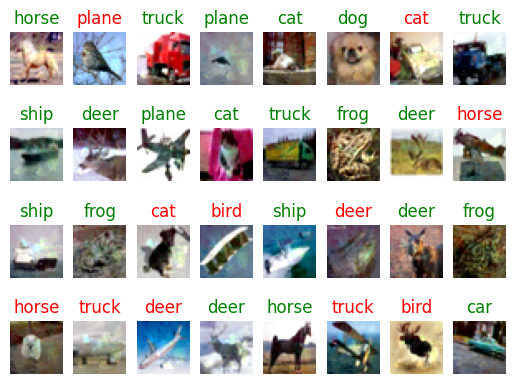

In [20]:
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


for data, label in ds_train:
    pre = model.predict(data).asnumpy()
    predicted = np.argmax(pre, 1)
    # print(predicted)
    ground_trues = label.asnumpy()
    data = data.asnumpy()
    
    data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
    
    
    plt.figure()
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        if predicted[i] == ground_trues[i]:
            plt.title("{}".format(classes[predicted[i]]), color="green")
        else:
            plt.title("{}".format(classes[predicted[i]]), color="red")
            print("the pic " + str(i) + " " + classes[predicted[i]] + "-->" + classes[ground_trues[i]])
        img = np.transpose(data[i], (1, 2, 0))
        plt.imshow(img)
        plt.axis("off")
    plt.show()
    plt.pause(0.1)

    
    break